<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="25%"/>
  </p>
  
# **Trabajo Práctico 2: Críticas Cinematográficas**
### **Grupo**: 11 - Los Pandas 🐼
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo Suster
### **Integrantes**:
- ### 106861 - Labollita, Francisco
- ### 102312 - Mundani Vegega, Ezequiel
- ###  97263 - Otegui, Matías Iñaki

# Modelo Red Neuronal aplicando Keras y Tensor Flow 1

Utilizando el dataset modificado, se entrena un modelo de Red Neuronal y luego se lo optimiza mediante gridsearch.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer, classification_report

warnings.filterwarnings('ignore', 'is_sparse is deprecated')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(10, None)

In [3]:
reviews = pd.read_csv('train_clean.csv')

In [4]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews['review_es'])

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(reviews['review_es'])
padded_sequence = pad_sequences(encoded_docs, maxlen=300)

# Codificación de etiquetas
encoder = LabelEncoder()
sentimientos = encoder.fit_transform(reviews['sentimiento'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequence, sentimientos, test_size=0.2, random_state=1)

## Se entrena un modelo de Red Neuronal con una capa escondida

In [5]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=300))
model.add(LSTM(100, kernel_regularizer=l2(0.01),
          recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])

# Entrenamiento del modelo
model.fit(X_train, y_train, validation_data=(
    X_test, y_test), epochs=3, batch_size=64)

# Predicciones
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

Epoch 1/3
625/625 [==============================] - 118s 188ms/step - loss: 1.1339 - accuracy: 0.7863 - val_loss: 0.6581 - val_accuracy: 0.8539
Epoch 2/3
625/625 [==============================] - 111s 178ms/step - loss: 0.4971 - accuracy: 0.8653 - val_loss: 0.4068 - val_accuracy: 0.8747
Epoch 3/3
313/313 [==============================] - 10s 32ms/step


Matriz de confusión de los datos de prueba


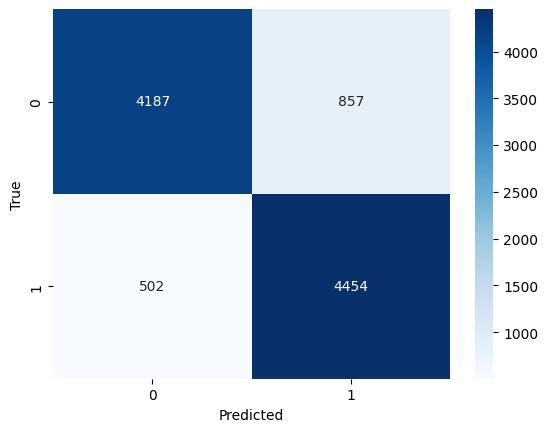

In [6]:
print("Matriz de confusión de los datos de prueba")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [7]:
accuracy = accuracy_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_train, y_train_pred))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.904
Recall:  0.931
Precision:  0.883
F1 score:  0.907
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     19956
           1       0.88      0.93      0.91     20044

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



In [8]:
accuracy=accuracy_score(y_test,y_test_pred)
recall=recall_score(y_test,y_test_pred)
f1=f1_score(y_test,y_test_pred)
precision=precision_score(y_test, y_test_pred)

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_test, y_test_pred))

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.864
Recall:  0.899
Precision:  0.839
F1 score:  0.868
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      5044
           1       0.84      0.90      0.87      4956

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



## Optimización de hiperparámetros mediante GridSearch

In [9]:
def create_model(optimizer='rmsprop'):
    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length=300))
    model.add(LSTM(100, kernel_regularizer=l2(0.01),
              recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [11]:
model = KerasClassifier(model=create_model, verbose=0)

param_grid = {
    'epochs': [3, 5],
    'batch_size': [64, 128],
    'optimizer': ['rmsprop', 'adam']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
scoring=make_scorer(f1_score, greater_is_better=True)

grid_result = grid.fit(X_train, y_train)

print(f"Mejor: {grid_result.best_score_} usando {grid_result.best_params_}")

Mejor: 0.8495999916872078 usando {'batch_size': 64, 'epochs': 5, 'optimizer': 'rmsprop'}


Matriz de confusión de los datos de prueba


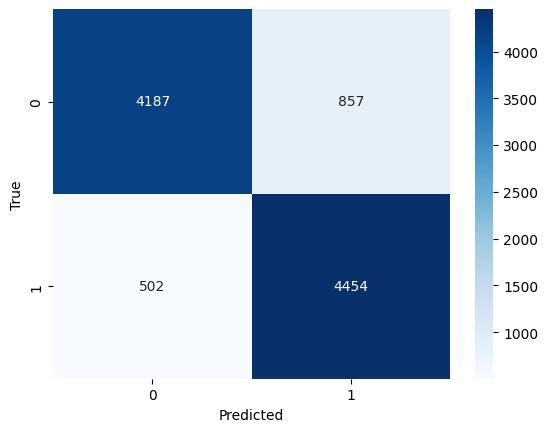

In [12]:
print("Matriz de confusión de los datos de prueba")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [13]:
accuracy = accuracy_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_train, y_train_pred))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.904
Recall:  0.931
Precision:  0.883
F1 score:  0.907
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     19956
           1       0.88      0.93      0.91     20044

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



In [14]:
accuracy=accuracy_score(y_test,y_test_pred)
recall=recall_score(y_test,y_test_pred)
f1=f1_score(y_test,y_test_pred)
precision=precision_score(y_test, y_test_pred)

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_test, y_test_pred))

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.864
Recall:  0.899
Precision:  0.839
F1 score:  0.868
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      5044
           1       0.84      0.90      0.87      4956

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



## Predicción del conjunto test

In [16]:
test_df = pd.read_csv('test_clean.csv')

encoded_docs_test = tokenizer.texts_to_sequences(test_df['review_es'])
padded_sequence_test = pad_sequences(encoded_docs_test, maxlen=300)

predictions = grid_result.predict(padded_sequence_test)
y_pred_test = ['positivo' if pred >
               0.5 else 'negativo' for pred in predictions]

test_df['sentimiento'] = y_pred_test
test_df.drop("review_es", axis=1, inplace=True)
test_df.to_csv('sample_solution.csv', index=False)